In [1]:
# based on
# https://scikit-learn.org/1.5/auto_examples/ensemble/plot_gradient_boosting_quantile.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-quantile-py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
# plt.style.use(['default'])
# plt.style.use(['science', 'notebook', 'bright'])
plt.style.use(['science', 'notebook', 'muted'])

# plt.style.use(['science', 'notebook', 'grid'])

plt.rcParams['text.usetex'] = False

In [3]:

from sklearn.model_selection import train_test_split


def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()


heteroscedastic noise

In [4]:
# sigma = 0.5 + X.ravel() / 10
sigma = 0.5 + X.ravel() / 30
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
y = expected_y + noise

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [6]:
mask = (X_train[:,0] > 4) & (X_train[:,0] < 6)
X_train = X_train[~mask]
y_train = y_train[~mask]

mask = (X_test[:,0] > 4) & (X_test[:,0] < 6)
X_test = X_test[~mask]
y_test = y_test[~mask]

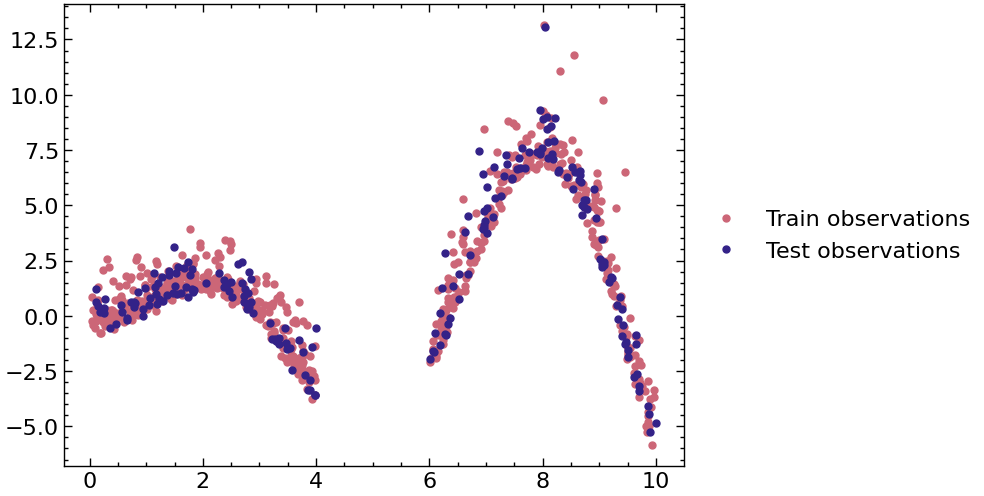

In [7]:
plt.plot(X_train, y_train, "C0.", markersize=10, label="Train observations")
plt.plot(X_test, y_test, "C1.", markersize=10, label="Test observations")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

In [9]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

In [10]:
all_models['mse']

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_leaf=9,
                          min_samples_split=9, n_estimators=200)

In [11]:
# xx = np.atleast_2d(np.linspace(-25, 35, 1000)).T
xx = np.atleast_2d(np.linspace(-5, 15, 1000)).T

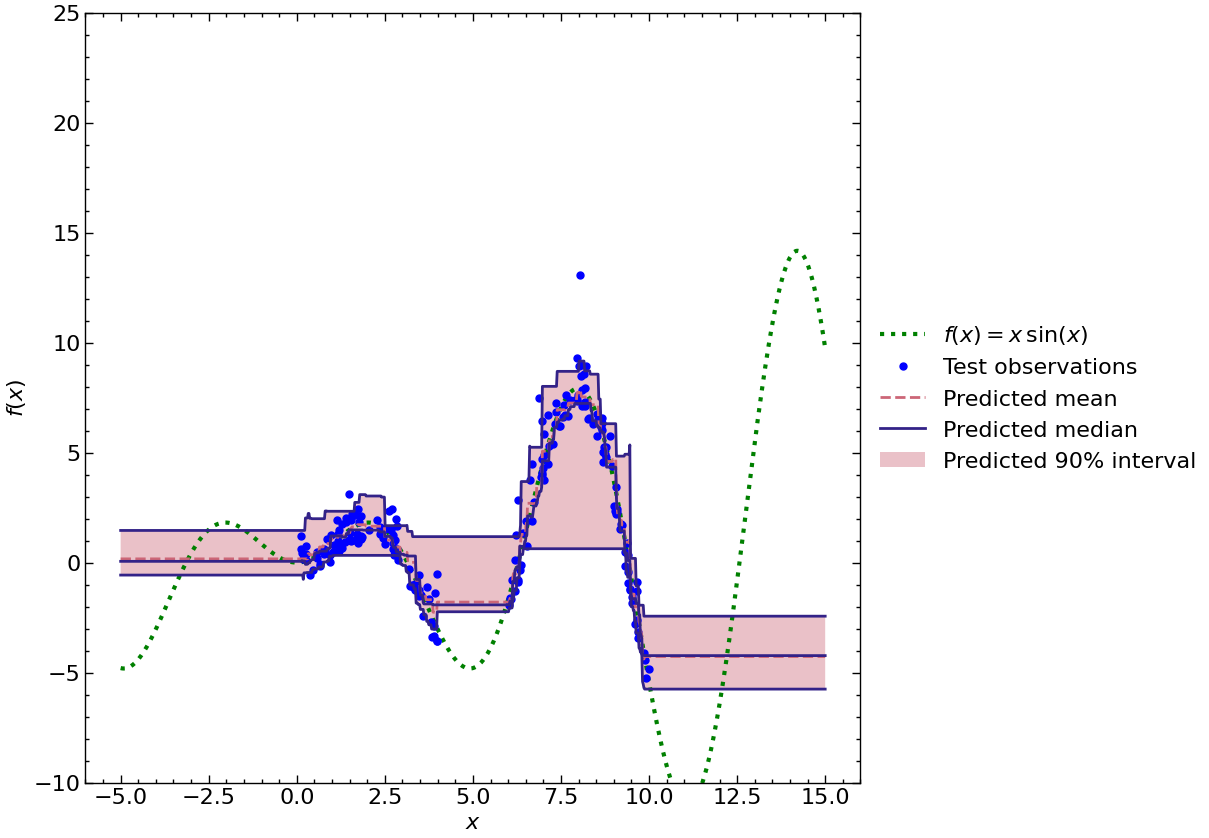

In [12]:
y_pred = all_models["mse"].predict(xx)
y_lower = all_models["q 0.05"].predict(xx)
y_upper = all_models["q 0.95"].predict(xx)
y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_pred, "C0--", label="Predicted mean")
plt.plot(xx, y_med, "C1-", label="Predicted median")
plt.plot(xx, y_upper, "C1-")
plt.plot(xx, y_lower, "C1-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

As we can see the model doesn't have good uncertainty estimates outside the training data

# Append synthetic OOD to training data

In [13]:
import sklearn.mixture

In [14]:
gmm_train = sklearn.mixture.GaussianMixture(n_components=10).fit(X_train)

In [216]:
X_synth = gmm_train.sample(5000)[0]

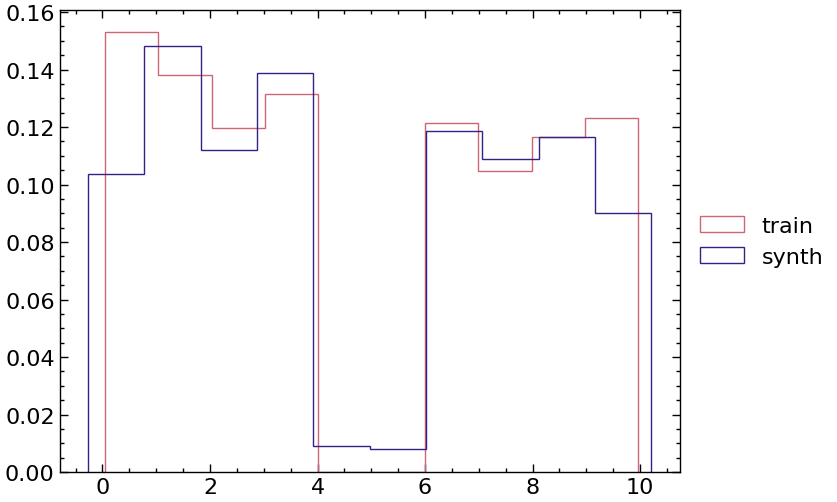

In [217]:
plt.hist(X_train, density=True, histtype='step', label='train');
plt.hist(X_synth, density=True, histtype='step', label='synth');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We want to generate data OUTSIDE the training set

we need a threshold likelihood

In [218]:
threshold_logprob = gmm_train.score_samples(X_train).min()

now we generate samples over the whole doman (in- and out-)
and use the threhsold logprob to only keep the out-of-domain samples

In [490]:
np.random.uniform([0, -1], [1, 2], size=(1000, 2))[:,1].min()

-0.9994168129108802

In [491]:
np.random.uniform([0, -1], [1, 2], size=(1000, 2))[:,1].max()

1.9980081323143315

In [492]:
synthetic_data_domain=[(0, 1), (-1, 2)]

In [493]:
[v[0] for v in synthetic_data_domain]


[0, -1]

In [494]:
[v[1] for v in synthetic_data_domain]


[1, 2]

In [219]:
X_synth_all_domain = np.random.uniform(xx.min(), xx.max(), (2000, 1))
logprob_all_domain = gmm_train.score_samples(X_synth_all_domain)

In [220]:
mask = logprob_all_domain > threshold_logprob

In [221]:
X_synth_in_domain = X_synth_all_domain[mask]
X_synth_out_domain = X_synth_all_domain[~mask]

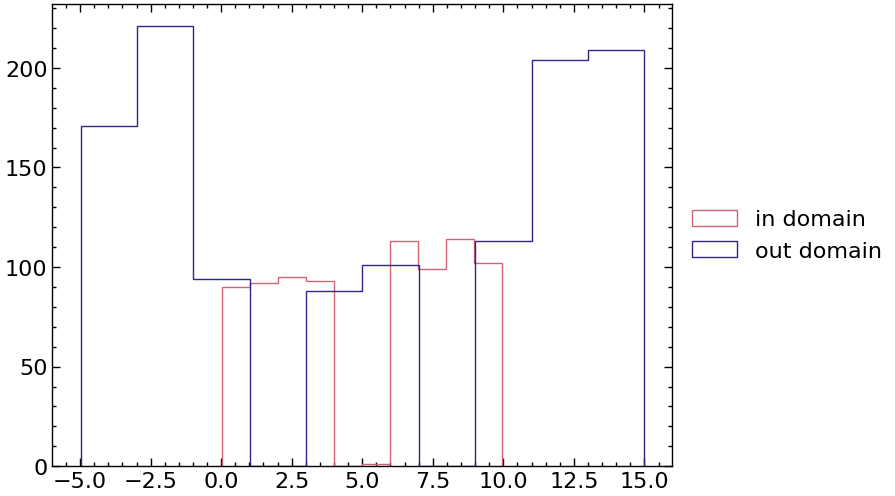

In [222]:
plt.hist(X_synth_in_domain, histtype='step', label='in domain')
plt.hist(X_synth_out_domain, histtype='step', label='out domain')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Now we know where to add data (in terms of the X axis)

we need to know where to place the synthetic data on the y-axis

Lets just use the mean of the data and some multiple of the standard deviation
to parameterise a Normal distribution

In [223]:
# # get the number of samples that allows us to divide by 2.

# n_ood = int(np.ceil(X_synth_out_domain.shape[0] // 2) * 2)
# X_synth_out_domain = X_synth_out_domain[:n_ood]

# # create synthetic target samples which have 'distance awarenss' I think there is probably a better way to do this...

# y_synth_ood_a = np.random.normal(y_train.mean() * np.abs(X_synth_out_domain[:,0]), y_train.std(), size=n_ood)
# y_synth_ood_b = np.random.normal(-y_train.mean() * np.abs(X_synth_out_domain[:,0]), y_train.std(), size=n_ood)

# y_synth_ood = np.concatenate([y_synth_ood_a[:n_ood//2], y_synth_ood_b[:n_ood//2]])

In [224]:
# n_ood = len(X_synth_out_domain)
# y_synth_ood = np.random.normal(y_train.mean(), y_train.std(), size=n_ood)

In [225]:
# n_ood = len(X_synth_out_domain)
# y_synth_ood = np.random.normal(y_train.mean(), y_train.std()*np.abs(X_synth_out_domain[:,0])/10, size=n_ood)

In [226]:
# the uncertainty in the OOD data should be dependent on the distance to the training set.
# similar to what MACEst does? https://arxiv.org/abs/2109.01531

In [466]:

from sklearn.neighbors import NearestNeighbors
def compute_distance_to_nearest_training_point(X_train, y_train, X_synth):
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X_train)
    distances, indices = nbrs.kneighbors(X_synth)
    return distances, indices


n_ood = len(X_synth_out_domain)
distances, indices = compute_distance_to_nearest_training_point(X_train, y_train, X_synth_out_domain)

# the value of the target in the out of domain data is a N(mu=y.mean(), sigma = d(x_star, x))
# i.e. normally distributed data with a mean the is taken from the training data
# and heteroskedastic standard deviation that is a function of the distance to the training data
# so that if we are close to the training data we have smaller error
# and if we are far from training data we have larger error
# y_synth_ood = np.random.normal(y_train.mean(), 5*distances)[:,0]

# scaling_factor = 5
scaling_factor = 1

# maybe the expected value should be the nearest training point?
# y_synth_ood = np.random.normal(y_train[indices], scaling_factor*distances**2)[:,0]

sigma_sys = scaling_factor*distances**2
sigma_stat = y_train.std()
sigma_total = sigma_sys + sigma_stat

y_synth_ood = np.random.normal(y_train[indices], sigma_total)[:,0]

 # 

# y_synth_ood = np.random.normal(y_train[indices], y_train.std())[:,0]

In [467]:
n_ood

1201

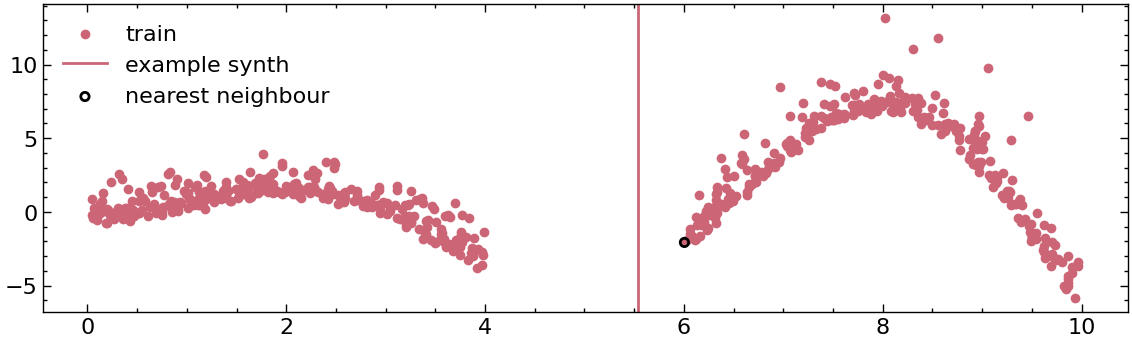

In [468]:
plt.figure(figsize=(14, 4), dpi=100)
plt.scatter(X_train, y_train)
plt.axvline(X_synth_out_domain[0])
plt.scatter(X_train[indices[0]], y_train[indices[0]], fc='none', ec='k', lw=2)
plt.legend(['train', 'example synth', 'nearest neighbour'])

In [469]:
distances[0]

array([0.46839889])

In [470]:
X_synth_out_domain[0] - X_train[indices[0]]

array([[-0.46839889]])

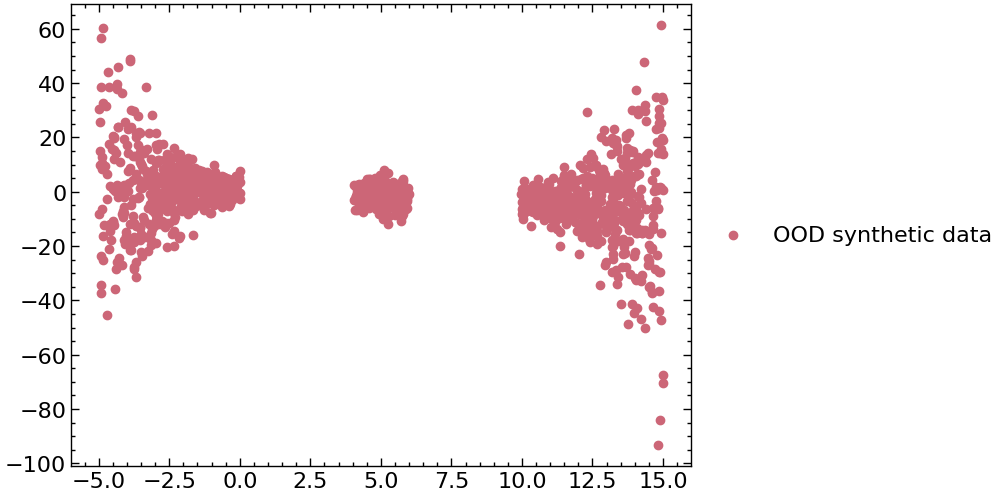

In [471]:
plt.scatter(X_synth_out_domain, y_synth_ood, label='OOD synthetic data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

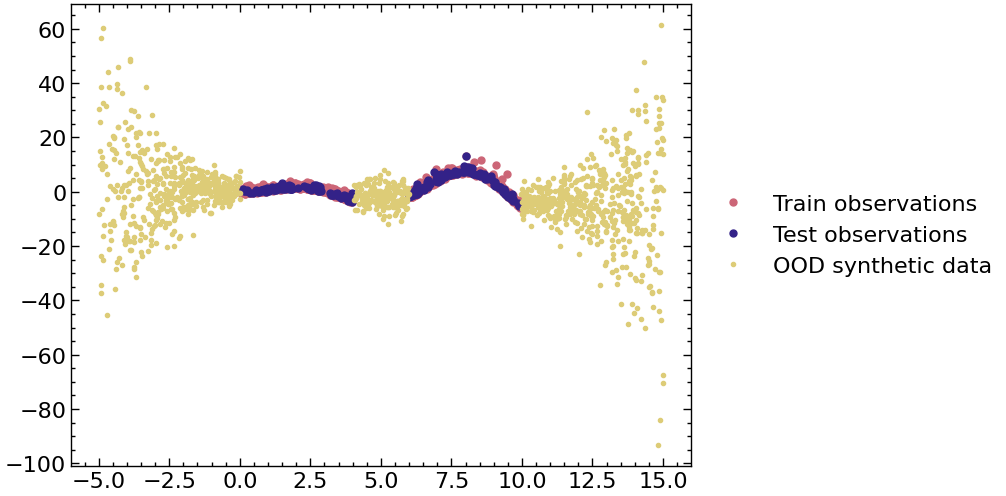

In [472]:
plt.plot(X_train, y_train, "C0.", markersize=10, label="Train observations")
plt.plot(X_test, y_test, "C1.", markersize=10, label="Test observations")
plt.plot(X_synth_out_domain, y_synth_ood, "C2.", label='OOD synthetic data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [473]:
X_train_aug = np.r_[X_train, X_synth_out_domain]
y_train_aug = np.concatenate([y_train, y_synth_ood])

In [474]:
X_train.shape

(606, 1)

In [475]:
X_train_aug.shape

(1807, 1)

In [476]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train_aug, y_train_aug)

In [477]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train_aug, y_train_aug)

In [478]:
all_models['mse']

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_leaf=9,
                          min_samples_split=9, n_estimators=200)

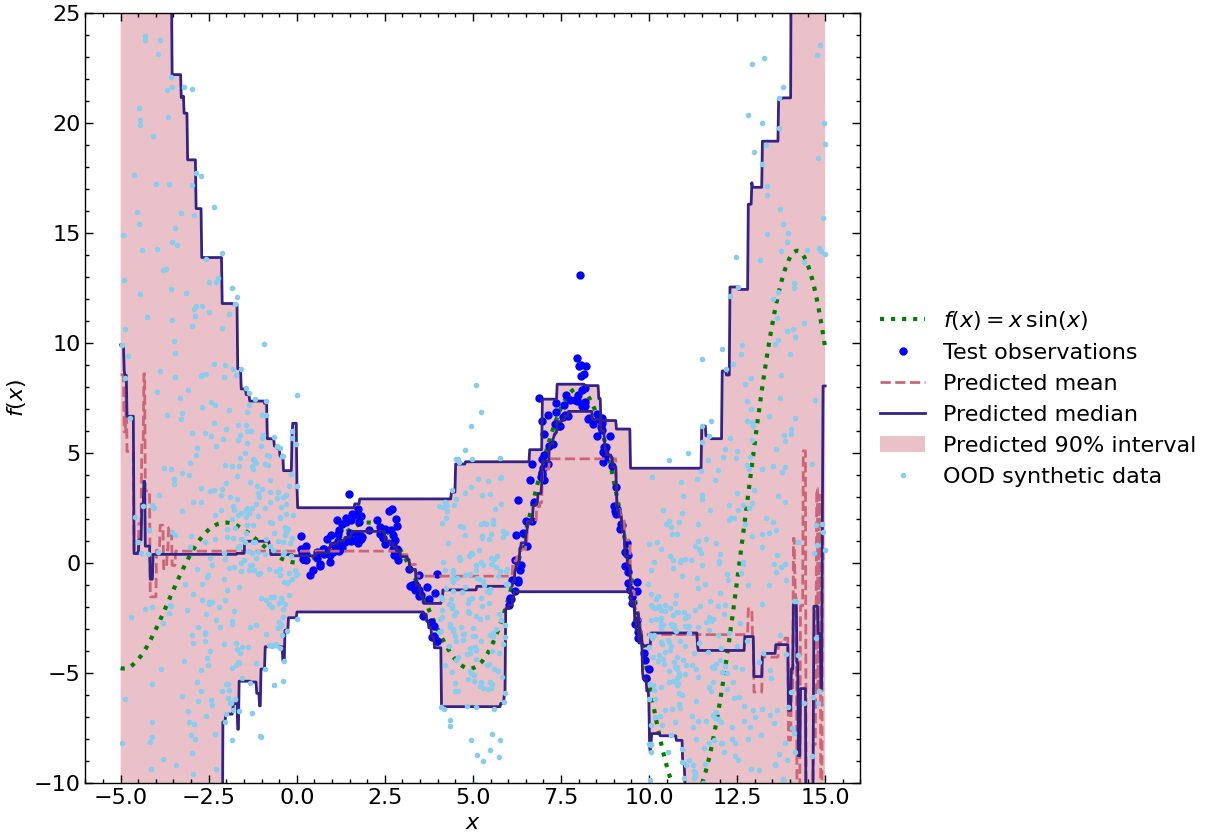

In [479]:
y_pred = all_models["mse"].predict(xx)
y_lower = all_models["q 0.05"].predict(xx)
y_upper = all_models["q 0.95"].predict(xx)
y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_pred, "C0--", label="Predicted mean")
plt.plot(xx, y_med, "C1-", label="Predicted median")
plt.plot(xx, y_upper, "C1-")
plt.plot(xx, y_lower, "C1-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)

plt.plot(X_synth_out_domain, y_synth_ood, "C4.", label='OOD synthetic data')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [480]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint

param_grid = dict(
    learning_rate=[0.05, 0.1, 0.2],
    max_depth=[2, 5, 10],
    min_samples_leaf=[1, 5, 10, 20],
    min_samples_split=[5, 10, 20, 30, 50],
)
alpha = 0.05
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss
)
gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, random_state=0)
search_05p = HalvingRandomSearchCV(
    gbr,
    param_grid,
    resource="n_estimators",
    max_resources=250,
    min_resources=50,
    scoring=neg_mean_pinball_loss_05p_scorer,
    n_jobs=2,
    random_state=0,
).fit(X_train_aug, y_train_aug)
pprint(search_05p.best_params_)

from sklearn.base import clone

alpha = 0.95
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss
)
search_95p = clone(search_05p).set_params(
    estimator__alpha=alpha,
    scoring=neg_mean_pinball_loss_95p_scorer,
)
search_95p.fit(X_train_aug, y_train_aug)
pprint(search_95p.best_params_)

{'learning_rate': 0.2,
 'max_depth': 2,
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'n_estimators': 150}
{'learning_rate': 0.2,
 'max_depth': 2,
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'n_estimators': 150}


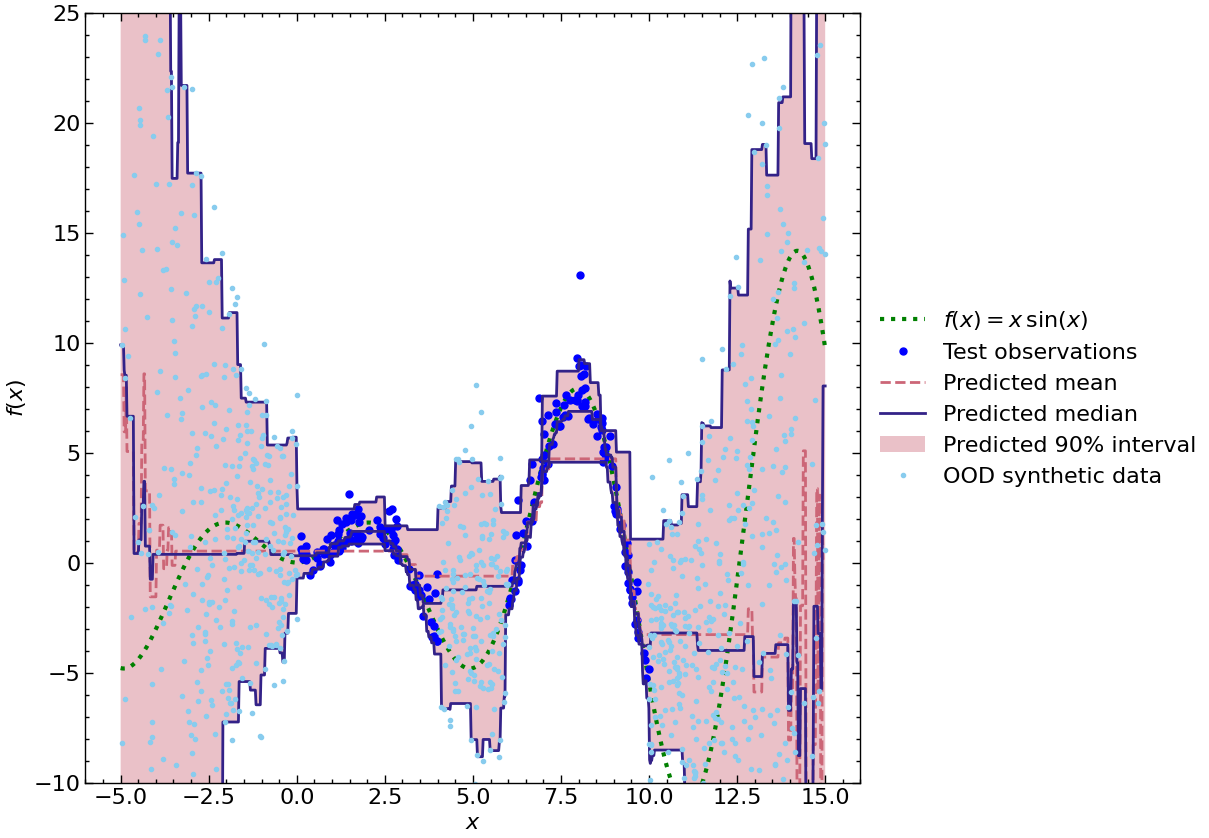

In [481]:
y_pred = all_models["mse"].predict(xx)
# y_lower = all_models["q 0.05"].predict(xx)
# y_upper = all_models["q 0.95"].predict(xx)

y_lower = search_05p.predict(xx)
y_upper = search_95p.predict(xx)

y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_pred, "C0--", label="Predicted mean")
plt.plot(xx, y_med, "C1-", label="Predicted median")
plt.plot(xx, y_upper, "C1-")
plt.plot(xx, y_lower, "C1-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)

plt.plot(X_synth_out_domain, y_synth_ood, "C4.", label='OOD synthetic data')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [482]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X_train, y_train)

In [483]:
gpr_pred, gpr_pstd = gpr.predict(xx, return_std=True)

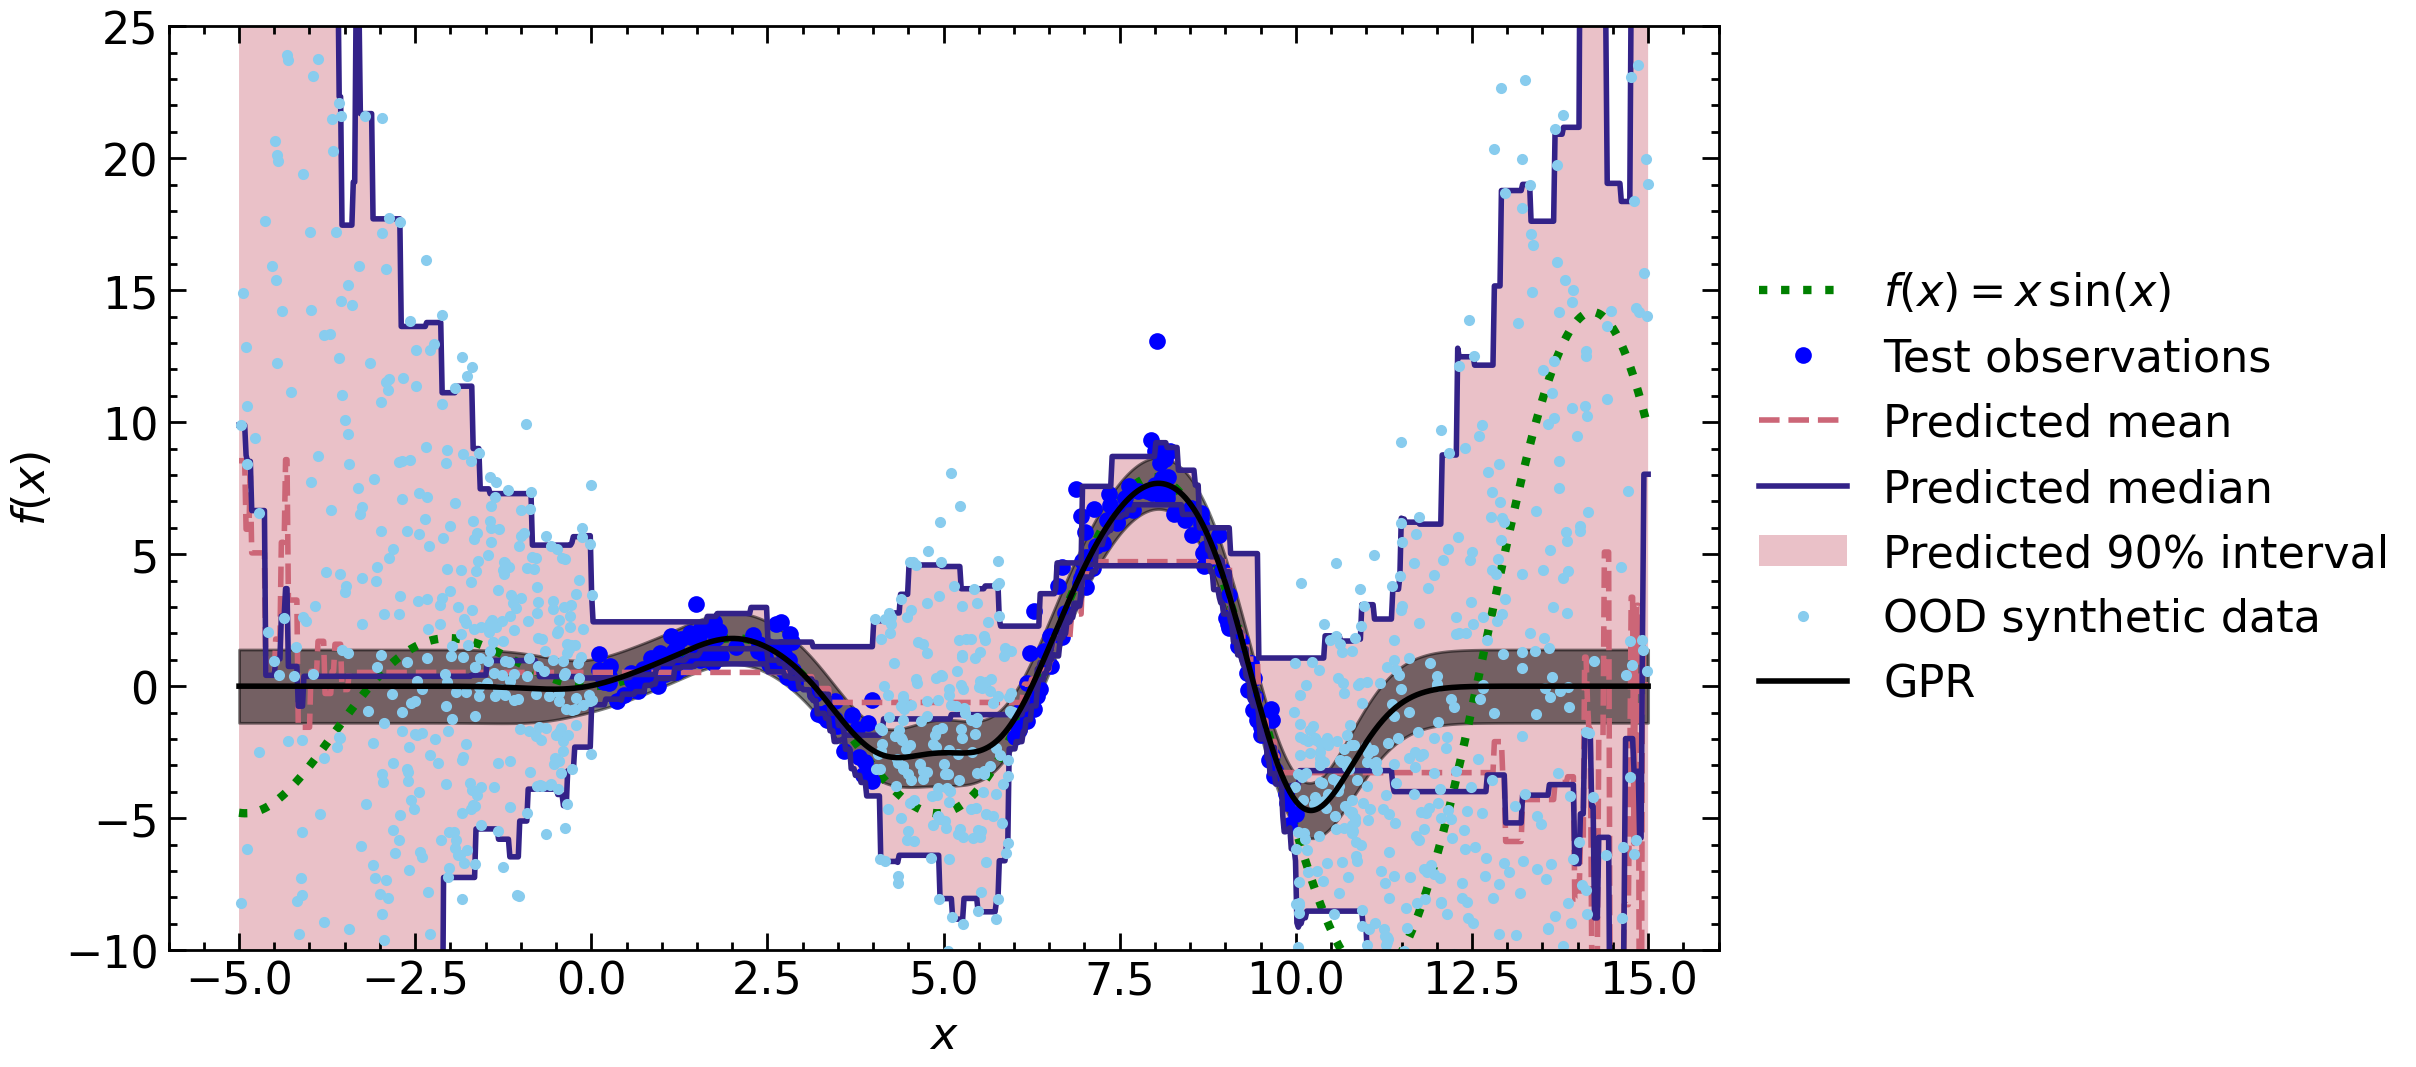

In [484]:
y_pred = all_models["mse"].predict(xx)
# y_lower = all_models["q 0.05"].predict(xx)
# y_upper = all_models["q 0.95"].predict(xx)

y_lower = search_05p.predict(xx)
y_upper = search_95p.predict(xx)

y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(10, 6), dpi=200)
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_pred, "C0--", label="Predicted mean")
plt.plot(xx, y_med, "C1-", label="Predicted median")
plt.plot(xx, y_upper, "C1-")
plt.plot(xx, y_lower, "C1-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)

plt.plot(X_synth_out_domain, y_synth_ood, "C4.", label='OOD synthetic data')


plt.plot(xx, gpr_pred, label='GPR', c='k')
plt.fill_between(xx[:,0], gpr_pred-gpr_pstd, gpr_pred+gpr_pstd, alpha=0.5, color='k')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()